In [1]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

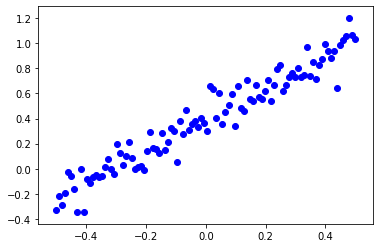

In [2]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [3]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

w: variable W([[-1.4931672]])
b: variable b([0.])
Operations on chainer.Variable: variable([[121.506836]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[-1.4931672]] [[121.506836]]


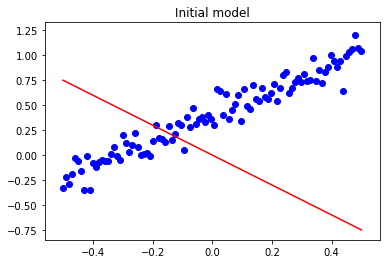

In [4]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [5]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

loss variable(0.8098396)
dloss/dW [[-0.4676172]]


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 0 loss: variable(0.9174026)
Itr 25 loss: variable(0.06432829)
Itr 50 loss: variable(0.01356265)
Itr 75 loss: variable(0.00985884)


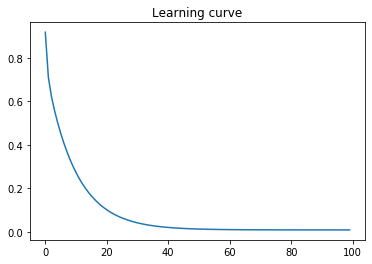

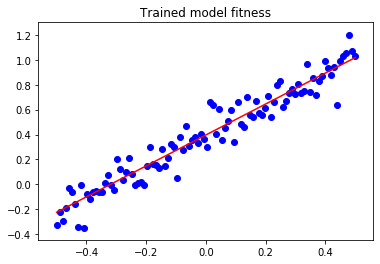

In [6]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []

alpha = 0.3 # learning rate

for i in range(100):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    loss.backward()
    model.W.data[:] -= alpha * model.W.grad[0]
    model.b.data[:] -= alpha * model.b.grad[0]
    
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)

plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


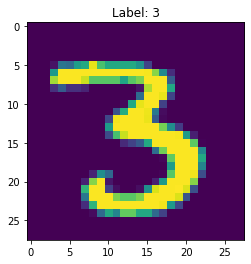

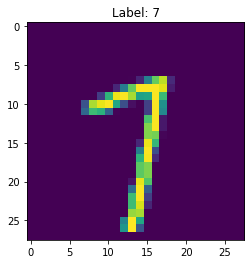

In [19]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [8]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
run(L.Linear(None, 10))

loss: 2.1918489933013916; accuracy: 0.1875
loss: 0.5800013411045074; accuracy: 0.8825
loss: 0.47375603556632995; accuracy: 0.8675
loss: 0.46720222175121306; accuracy: 0.87
loss: 0.36728362143039706; accuracy: 0.89
loss: 0.3495238894224167; accuracy: 0.91
loss: 0.31909449517726896; accuracy: 0.91
loss: 0.30772825866937636; accuracy: 0.9125
loss: 0.32013860225677493; accuracy: 0.905
loss: 0.37382745653390886; accuracy: 0.91
loss: 0.31313637167215347; accuracy: 0.9175
loss: 0.3007394632697105; accuracy: 0.89
loss: 0.30144682228565217; accuracy: 0.9075
loss: 0.2381368973851204; accuracy: 0.92
loss: 0.2678225368261337; accuracy: 0.935
loss: 0.34469540536403653; accuracy: 0.905
loss: 0.2566246980428696; accuracy: 0.915
loss: 0.28418401777744295; accuracy: 0.915
loss: 0.24203905314207078; accuracy: 0.9325
loss: 0.3353258311748505; accuracy: 0.88
loss: 0.2845679956674576; accuracy: 0.9175
loss: 0.27997393429279327; accuracy: 0.9175
loss: 0.22361932635307313; accuracy: 0.9275
loss: 0.2307772442

Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [9]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        return self.l3(x)
run(MLP(200, 10))

loss: 2.363603115081787; accuracy: 0.125
loss: 0.3507451599836349; accuracy: 0.91
loss: 0.2878301352262497; accuracy: 0.91
loss: 0.18579482316970825; accuracy: 0.945
loss: 0.259389762878418; accuracy: 0.9275
loss: 0.19330302834510804; accuracy: 0.94
loss: 0.12892167150974274; accuracy: 0.9775
loss: 0.18337785631418227; accuracy: 0.9375
loss: 0.08951313614845276; accuracy: 0.9725
loss: 0.11571408331394195; accuracy: 0.9525
loss: 0.10818016350269317; accuracy: 0.96
loss: 0.15462807476520538; accuracy: 0.965
loss: 0.12477726757526397; accuracy: 0.96
loss: 0.08517790079116822; accuracy: 0.965
loss: 0.08789850652217865; accuracy: 0.9725
loss: 0.0467643940448761; accuracy: 0.9825
loss: 0.05383309990167618; accuracy: 0.9825
loss: 0.0878223705291748; accuracy: 0.9725
loss: 0.07051351517438889; accuracy: 0.9725
loss: 0.079512460231781; accuracy: 0.9675
loss: 0.06299753189086914; accuracy: 0.9675
loss: 0.10232635229825973; accuracy: 0.9625
loss: 0.0640937876701355; accuracy: 0.975
loss: 0.106424

Next you should try to implement logging test loss and see if the model is overfitting.

train_loss: 2.288259983062744; train_accuracy: 0.0625; test_loss: 2.2560754776000977; test_accuracy: 0.235
train_loss: 0.3340821459889412; train_accuracy: 0.915; test_loss: 0.421649661064148; test_accuracy: 0.8675
train_loss: 0.23996610701084137; train_accuracy: 0.9125; test_loss: 0.3255422630906105; test_accuracy: 0.9025
train_loss: 0.17255960643291474; train_accuracy: 0.9475; test_loss: 0.2684662115573883; test_accuracy: 0.91
train_loss: 0.2150869256258011; train_accuracy: 0.93; test_loss: 0.2775547361373901; test_accuracy: 0.9075
train_loss: 0.15243184953927993; train_accuracy: 0.9475; test_loss: 0.28711111009120943; test_accuracy: 0.9075
train_loss: 0.20211506247520447; train_accuracy: 0.93; test_loss: 0.243063348531723; test_accuracy: 0.9275
train_loss: 0.16024016320705414; train_accuracy: 0.94; test_loss: 0.31912871420383454; test_accuracy: 0.9025
train_loss: 0.11866206109523773; train_accuracy: 0.9575; test_loss: 0.17388325214385986; test_accuracy: 0.9375
train_loss: 0.153475686

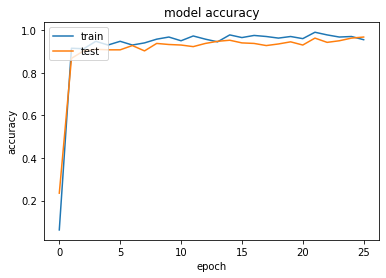

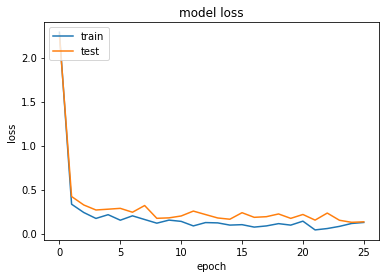

Highest Training accuracy: 0.99, highest test accuracy:0.9675


In [10]:
def better_run(model, batchsize=16, num_epochs=2, opt=chainer.optimizers.Adam(), enable_prt=True, train_dataset=train, test_dataset=test, shuffle_train_set=True):

    optimizer = opt # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train_dataset, batchsize, repeat=False, shuffle=shuffle_train_set)
        test_iter = chainer.iterators.SerialIterator(test_dataset, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["train_loss"].append(float(loss.data))
            stats["train_accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                for test_itr, test_batch in enumerate(test_iter):
                    test_xs = np.concatenate([datum[0][None, :] for datum in test_batch])
                    test_ys = np.array([datum[1] for datum in test_batch])
                    logits = model(test_xs)
                    loss = F.softmax_cross_entropy(logits, test_ys)
                    stats["test_loss"].append(float(loss.data))
                    stats["test_accuracy"].append(float((logits.data.argmax(1) == test_ys).sum() / batchsize))
                train_accuracy.append(np.mean(stats["train_accuracy"]))
                train_loss.append(np.mean(stats["train_loss"]))
                test_accuracy.append(np.mean(stats["test_accuracy"]))
                test_loss.append(np.mean(stats["test_loss"]))
                if enable_prt:
                    print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

    plt.plot(train_accuracy)
    plt.plot(test_accuracy)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    print("Highest Training accuracy: {}, highest test accuracy:{}".format(np.max(train_accuracy), np.max(test_accuracy)))
                    
better_run(MLP(200, 10))

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc

## Different Conv Networks
In the following, different convolution networks are examined for their performance.

### ConvNet

train_loss: 2.2966723442077637; train_accuracy: 0.0625; test_loss: 2.3029960441589354; test_accuracy: 0.075
train_loss: 1.6973277139663696; train_accuracy: 0.7675; test_loss: 1.6842311191558839; test_accuracy: 0.7875
train_loss: 1.6068544864654541; train_accuracy: 0.855; test_loss: 1.6455223894119262; test_accuracy: 0.8125
train_loss: 1.6216717910766603; train_accuracy: 0.8325; test_loss: 1.6396065950393677; test_accuracy: 0.825
train_loss: 1.5379803037643434; train_accuracy: 0.9275; test_loss: 1.5780980348587037; test_accuracy: 0.8825
train_loss: 1.5191964244842528; train_accuracy: 0.9425; test_loss: 1.5523113536834716; test_accuracy: 0.9125
train_loss: 1.5177594137191772; train_accuracy: 0.945; test_loss: 1.534015212059021; test_accuracy: 0.935
train_loss: 1.5127306985855102; train_accuracy: 0.945; test_loss: 1.5347458839416503; test_accuracy: 0.9325
train_loss: 1.5006143426895142; train_accuracy: 0.9625; test_loss: 1.5217105674743652; test_accuracy: 0.9425
train_loss: 1.500497798919

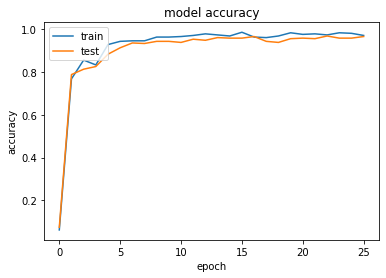

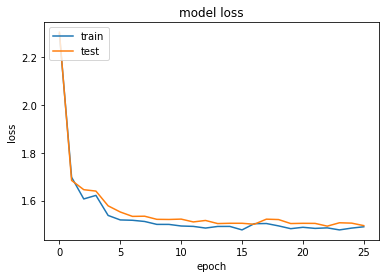

Highest Training accuracy: 0.985, highest test accuracy:0.9675


In [11]:
from chainer import Chain

class ConvNet(Chain):
    def __init__(self):
        super(ConvNet, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=1, out_channels=8, ksize=5, stride=1)
            self.conv2 = L.Convolution2D(
                in_channels=8, out_channels=16, ksize=5, stride=1)
            self.fc3 = L.Linear(None, 10)
            
    def __call__(self, x):
        x = x.reshape(x.shape[0],1,28,28)
        x = F.relu(self.conv1(x))
        x = F.max_pooling_2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        return F.softmax(self.fc3(x))
    
better_run(ConvNet())

### LeNet5 (parameters slightly adjusted)
Source [https://docs.chainer.org/en/stable/examples/cnn.html#lenet5](https://docs.chainer.org/en/stable/examples/cnn.html#lenet5)

train_loss: 2.2842798233032227; train_accuracy: 0.1875; test_loss: 2.422989053726196; test_accuracy: 0.0975
train_loss: 2.2468997859954833; train_accuracy: 0.1625; test_loss: 2.2271813106536866; test_accuracy: 0.1425
train_loss: 0.5694998002052307; train_accuracy: 0.8025; test_loss: 0.6375085467100143; test_accuracy: 0.805
train_loss: 0.34164356112480165; train_accuracy: 0.89; test_loss: 0.4317683231830597; test_accuracy: 0.8725
train_loss: 0.252955339550972; train_accuracy: 0.92; test_loss: 0.39553918421268464; test_accuracy: 0.8825
train_loss: 0.22629218816757202; train_accuracy: 0.9275; test_loss: 0.2780270653963089; test_accuracy: 0.915
train_loss: 0.1820290517807007; train_accuracy: 0.9475; test_loss: 0.341024414896965; test_accuracy: 0.8875
train_loss: 0.2213558042049408; train_accuracy: 0.93; test_loss: 0.23731884181499482; test_accuracy: 0.9175
train_loss: 0.12910427927970886; train_accuracy: 0.96; test_loss: 0.1850034075975418; test_accuracy: 0.945
train_loss: 0.18100171387195

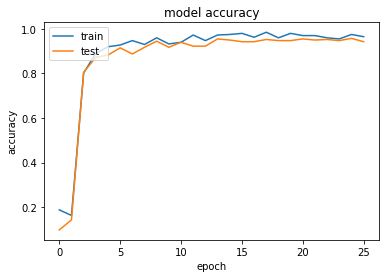

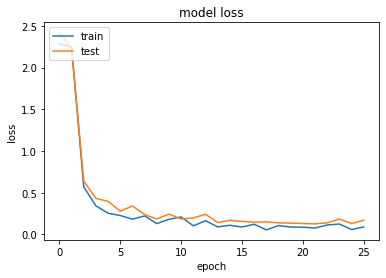

Highest Training accuracy: 0.985, highest test accuracy:0.9575


In [21]:
from chainer import Chain

class LeNet5(Chain):
    def __init__(self):
        super(LeNet5, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=1, out_channels=6, ksize=5, stride=1)
            self.conv2 = L.Convolution2D(
                in_channels=6, out_channels=16, ksize=5, stride=1)
            self.conv3 = L.Convolution2D(
                in_channels=16, out_channels=120, ksize=4, stride=1)
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(512, 10)

    def __call__(self, x):
        x = x.reshape(x.shape[0],1,28,28)
        h = F.sigmoid(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.sigmoid(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.sigmoid(self.conv3(h))
        h = F.sigmoid(self.fc4(h))
        if chainer.config.train:
            return self.fc5(h)
        return F.softmax(self.fc5(h))
    
better_run(LeNet5())

### VGG16 with Less Nodes per Layer
Source: [https://docs.chainer.org/en/stable/examples/cnn.html#vgg16](https://docs.chainer.org/en/stable/examples/cnn.html#vgg16)

In [ ]:
class VGG16(chainer.ChainList):
    def __init__(self):
        super(VGG16, self).__init__(
            VGGBlock(64),
            VGGBlock(128),
            VGGBlock(256, 3),
            VGGBlock(512, 3),
            VGGBlock(512, 3, True))

    def __call__(self, x):
        x=x.reshape(x.shape[0],1,28,28)
        for f in self.children():
            x = f(x)
        if chainer.config.train:
            return x
        return F.softmax(x)


class VGGBlock(chainer.Chain):
    def __init__(self, n_channels, n_convs=2, fc=False):
        w = chainer.initializers.HeNormal()
        super(VGGBlock, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, n_channels, 3, 1, 1, initialW=w)
            self.conv2 = L.Convolution2D(
                n_channels, n_channels, 3, 1, 1, initialW=w)
            if n_convs == 3:
                self.conv3 = L.Convolution2D(
                    n_channels, n_channels, 3, 1, 1, initialW=w)
            if fc:
                self.fc4 = L.Linear(None, 1024, initialW=w)
                self.fc5 = L.Linear(1024, 1024, initialW=w)
                self.fc6 = L.Linear(2048, 10, initialW=w)

        self.n_convs = n_convs
        self.fc = fc

    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        if self.n_convs == 3:
            h = F.relu(self.conv3(h))
        h = F.max_pooling_2d(h, 2, 2)
        if self.fc:
            h = F.dropout(F.relu(self.fc4(h)))
            h = F.dropout(F.relu(self.fc5(h)))
            h = self.fc6(h)
        return h
    
better_run(VGG16())

### RestNet152
Source: [https://docs.chainer.org/en/stable/examples/cnn.html#resnet152](https://docs.chainer.org/en/stable/examples/cnn.html#resnet152)


In [ ]:
class ResNet152(chainer.Chain):
    def __init__(self, n_blocks=[3, 8, 36, 3]):
        w = chainer.initializers.HeNormal()
        super(ResNet152, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 64, 7, 2, 3, initialW=w, nobias=True)
            self.bn1 = L.BatchNormalization(64)
            self.res2 = ResBlock(n_blocks[0], 64, 64, 256, 1)
            self.res3 = ResBlock(n_blocks[1], 256, 128, 512)
            self.res4 = ResBlock(n_blocks[2], 512, 256, 1024)
            self.res5 = ResBlock(n_blocks[3], 1024, 512, 2048)
            self.fc6 = L.Linear(2048, 10)

    def __call__(self, x):
        x=x.reshape(x.shape[0],1,28,28)
        h = self.bn1(self.conv1(x))
        h = F.max_pooling_2d(F.relu(h), 2, 2)
        h = self.res2(h)
        h = self.res3(h)
        h = self.res4(h)
        h = self.res5(h)
        h = F.average_pooling_2d(h, h.shape[2:], stride=1)
        h = self.fc6(h)
        if chainer.config.train:
            return h
        return F.softmax(h)


class ResBlock(chainer.ChainList):
    def __init__(self, n_layers, n_in, n_mid, n_out, stride=2):
        super(ResBlock, self).__init__()
        self.add_link(BottleNeck(n_in, n_mid, n_out, stride, True))
        for _ in range(n_layers - 1):
            self.add_link(BottleNeck(n_out, n_mid, n_out))

    def __call__(self, x):
        for f in self.children():
            x = f(x)
        return x


class BottleNeck(chainer.Chain):
    def __init__(self, n_in, n_mid, n_out, stride=1, proj=False):
        w = chainer.initializers.HeNormal()
        super(BottleNeck, self).__init__()
        with self.init_scope():
            self.conv1x1a = L.Convolution2D(
                n_in, n_mid, 1, stride, 0, initialW=w, nobias=True)
            self.conv3x3b = L.Convolution2D(
                n_mid, n_mid, 3, 1, 1, initialW=w, nobias=True)
            self.conv1x1c = L.Convolution2D(
                n_mid, n_out, 1, 1, 0, initialW=w, nobias=True)
            self.bn_a = L.BatchNormalization(n_mid)
            self.bn_b = L.BatchNormalization(n_mid)
            self.bn_c = L.BatchNormalization(n_out)
            if proj:
                self.conv1x1r = L.Convolution2D(
                    n_in, n_out, 1, stride, 0, initialW=w, nobias=True)
                self.bn_r = L.BatchNormalization(n_out)
        self.proj = proj

    def __call__(self, x):
        h = F.relu(self.bn_a(self.conv1x1a(x)))
        h = F.relu(self.bn_b(self.conv3x3b(h)))
        h = self.bn_c(self.conv1x1c(h))
        if self.proj:
            x = self.bn_r(self.conv1x1r(x))
        return F.relu(h + x)
    
better_run(ResNet152())

#### Conclusion CNN
The smaller CNN have achieved roughly the same accuracy than the MDP on the test set. Training the larger CNN takes too long without GPU. Maybe even better results could be achieved using them.


## Adujst the Learning Rate

Default


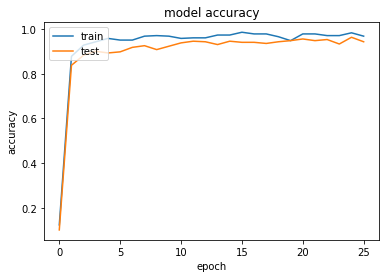

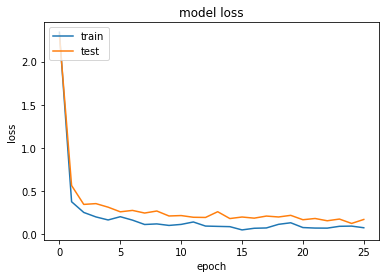

Highest Training accuracy: 0.985, highest test accuracy:0.9625
Result with alpha=0.1


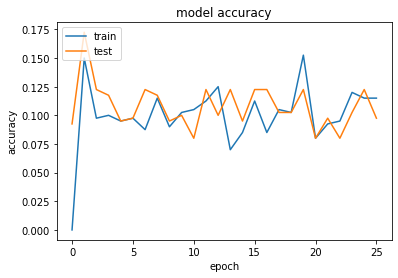

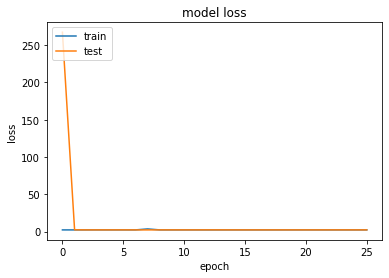

Highest Training accuracy: 0.1525, highest test accuracy:0.1725
Result with alpha=0.005


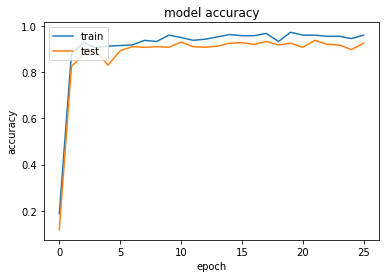

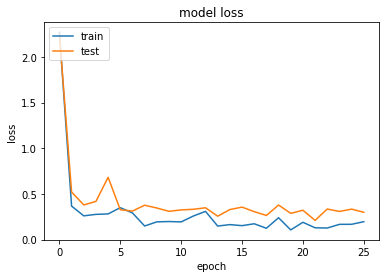

Highest Training accuracy: 0.9725, highest test accuracy:0.9375
Result with alpha=0.001


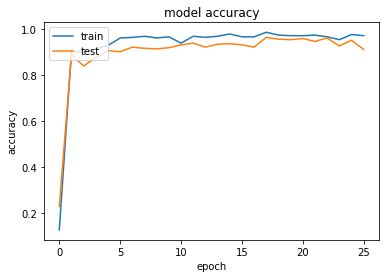

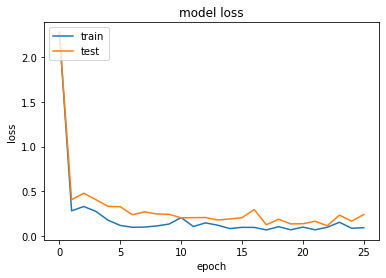

Highest Training accuracy: 0.9875, highest test accuracy:0.965
Result with alpha=0.0005


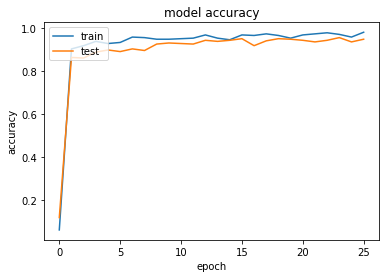

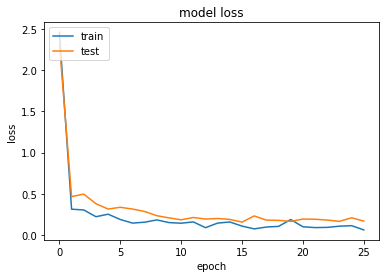

Highest Training accuracy: 0.9825, highest test accuracy:0.9575
Result with alpha=0.0001


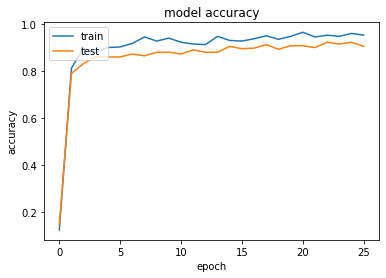

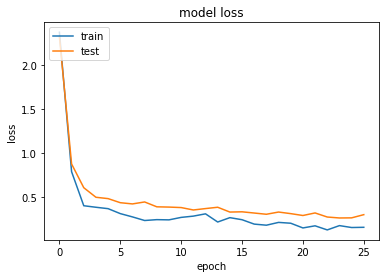

Highest Training accuracy: 0.965, highest test accuracy:0.9225
Result with alpha=5e-05


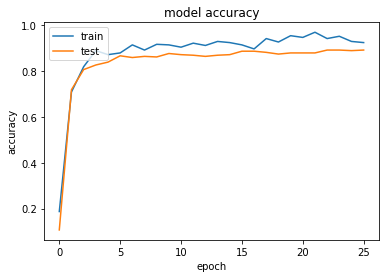

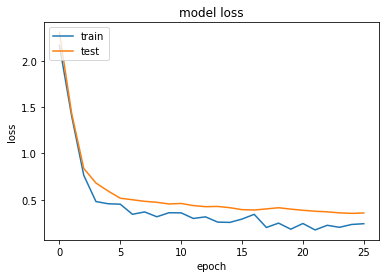

Highest Training accuracy: 0.9675, highest test accuracy:0.89


In [23]:
print("Default")                    
better_run(MLP(200, 10), opt=chainer.optimizers.Adam(), enable_prt=False)
for a in [0.1, 0.005, 0.001, 0.0005, 0.0001, 0.00005]:
    print("Result with alpha={}".format(a))
    better_run(MLP(200, 10), opt=chainer.optimizers.Adam(alpha=a), enable_prt=False)

#### Conclusion

The learning rate is a hyper parameter. If the learning rate is too high, the algorithm will not converge. If it is too low, the learning process takes too long.
The experiments indicates that better results can be achieved with adjustments of the learning rate (e.g. with alpha=0.01) than with the default setting. However, the Adam Optimizer has relatively many parameters. Often it is easier to increase the performance by tuning other hyperparameters (e.g. Dropout, Regularization, ...).


## With correlated Gradients


With sorted training set


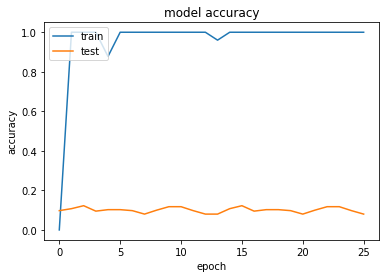

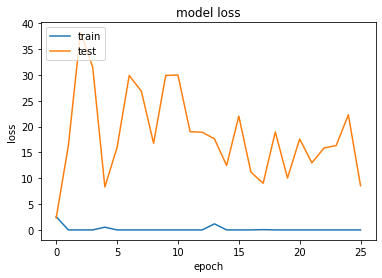

Highest Training accuracy: 1.0, highest test accuracy:0.1225
With sorted test set


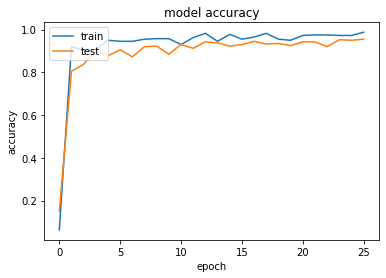

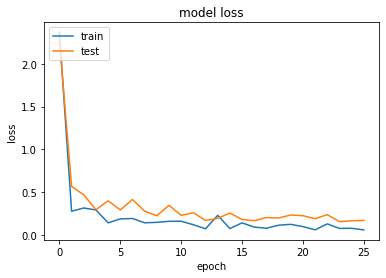

Highest Training accuracy: 0.9875, highest test accuracy:0.955
With sorted training and test set


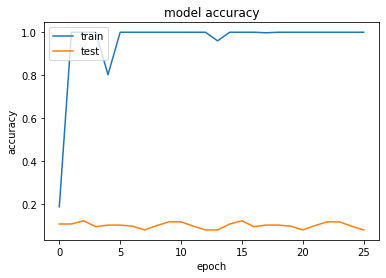

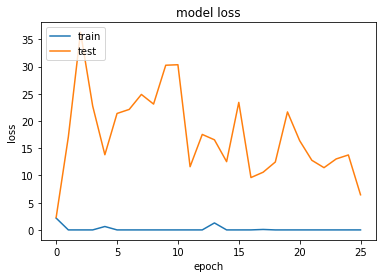

Highest Training accuracy: 1.0, highest test accuracy:0.1225


In [24]:
sortindex = np.argsort(train._datasets[1])
train_sorted = chainer.datasets.TupleDataset(train._datasets[0][sortindex], train._datasets[1][sortindex])
sortindex = np.argsort(test._datasets[1])
test_sorted = chainer.datasets.TupleDataset(test._datasets[0][sortindex], test._datasets[1][sortindex])


print("With sorted training set")
better_run(MLP(200, 10), train_dataset=train_sorted, test_dataset=test, enable_prt=False, shuffle_train_set=False)
print("With sorted test set")
better_run(MLP(200, 10), train_dataset=train, test_dataset=test_sorted, enable_prt=False, shuffle_train_set=False)
print("With sorted training and test set")
better_run(MLP(200, 10), train_dataset=train_sorted, test_dataset=test_sorted, enable_prt=False, shuffle_train_set=False)



#### Conclusion

When the test set is sorted, the training score is almost always 1, but the network does not generalize. This is because the network only has to learn how to find the correct number during training and then can always output this number until it changes. During testing this does not work anymore. 
In general, the training and test set should always be equally distributed. But if the data is sorted, this is no longer the case.